## SDGE Charges analysis

In [27]:
import yaml
import os
import pandas as pd
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [5]:
data_path = '../data'
filename = 'Electric_15_Minute_7-1-2023_7-1-2024_20240718.csv'
filepath = os.path.join(data_path, filename)

In [6]:
# Read the CSV file, skipping the first 13 lines
df = pd.read_csv(filepath, skiprows=13)

# Drop the "Meter Number" column
df.drop(columns=['Meter Number'], inplace=True)

# Convert "Date" to a date
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Convert "Start Time" to a time
df['Start Time'] = pd.to_datetime(df['Start Time']).dt.time

# Create a datetime object of the combination
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Start Time'].astype(str))

print(df.head())


         Date Start Time  Duration  Consumption  Generation    Net  \
0  2023-07-01   00:00:00        15        0.220         0.0  0.220   
1  2023-07-01   00:15:00        15        0.165         0.0  0.165   
2  2023-07-01   00:30:00        15        0.145         0.0  0.145   
3  2023-07-01   00:45:00        15        0.160         0.0  0.160   
4  2023-07-01   01:00:00        15        0.180         0.0  0.180   

             DateTime  
0 2023-07-01 00:00:00  
1 2023-07-01 00:15:00  
2 2023-07-01 00:30:00  
3 2023-07-01 00:45:00  
4 2023-07-01 01:00:00  


/var/folders/gy/xl1f5wqj7s5d372fjfdbh6q40000gn/T/ipykernel_90843/3092784056.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Start Time'] = pd.to_datetime(df['Start Time']).dt.time


In [25]:
# Define the rate structure
nem1 = yaml.safe_load(open('nem-1.yaml'))


In [13]:
def get_rate(row, rate_structure):
    dt = row["DateTime"]
    month = dt.month
    hour = dt.hour
    weekday = dt.weekday()
    day_type = "weekend" if weekday >= 5 else "weekday"

    for rate_period in rate_structure:
        start_month = rate_period["start-month"]
        end_month = rate_period["end-month"]
        if start_month <= end_month:
            in_period = start_month <= month <= end_month
        else:  # handles the wrap-around case (e.g., Nov to May)
            in_period = month >= start_month or month <= end_month
        
        if in_period:
            for slot in rate_period["time-slots"]:
                if slot["days"] == "all" or slot["days"] == day_type:
                    if slot["start-hour"] <= hour < slot["end-hour"]:
                        return rate_period["rate"]
    return None


In [26]:
df["Rate"] = df.apply(get_rate, axis=1, rate_structure=nem1)


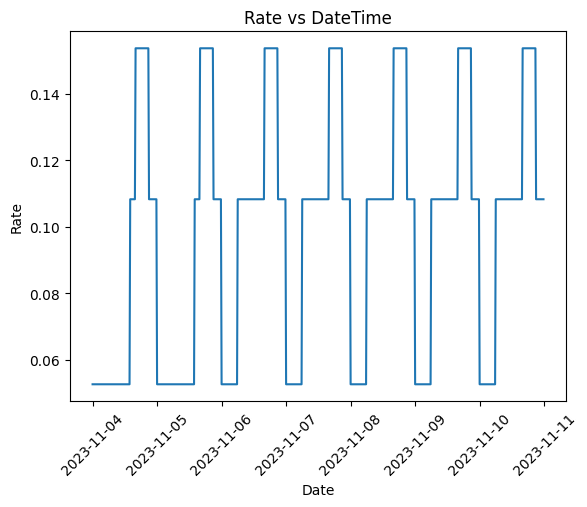

In [39]:
# Filter the dataframe for dates July 1 to July 7
filtered_df = df[(df['DateTime'].dt.date >= pd.to_datetime('2023-11-04').date()) & (df['DateTime'].dt.date <= pd.to_datetime('2023-11-10').date())]

# Plot the data
plt.plot(filtered_df['DateTime'], filtered_df['Rate'])
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Rate vs DateTime')

# Slant the x labels 45 degrees
plt.xticks(rotation=45)

plt.show()

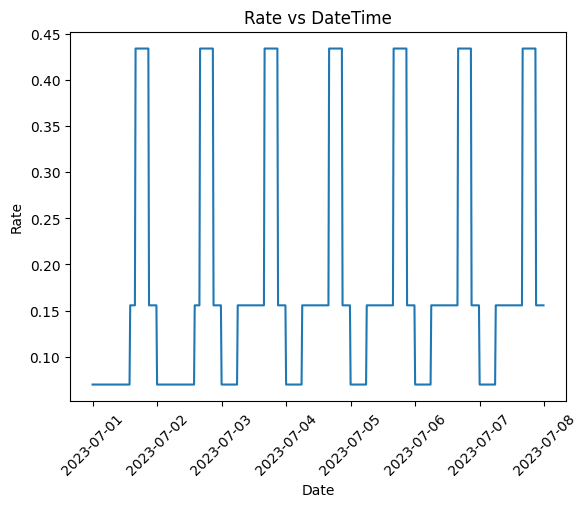

In [36]:
# Filter the dataframe for dates July 1 to July 7
filtered_df = df[(df['DateTime'].dt.date >= pd.to_datetime('2023-07-01').date()) & (df['DateTime'].dt.date <= pd.to_datetime('2023-07-07').date())]

# Plot the data
plt.plot(filtered_df['DateTime'], filtered_df['Rate'])
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Rate vs DateTime')

# Slant the x labels 45 degrees
plt.xticks(rotation=45)

plt.show()


In [33]:
filtered_df

,Date,Start Time,Duration,Consumption,Generation,Net,DateTime,Rate,cost
0,2023-07-01,00:00:00,15,0.220,0.0,0.220,2023-07-01 00:00:00,0.06967,0.015327
1,2023-07-01,00:15:00,15,0.165,0.0,0.165,2023-07-01 00:15:00,0.06967,0.011496
2,2023-07-01,00:30:00,15,0.145,0.0,0.145,2023-07-01 00:30:00,0.06967,0.010102
3,2023-07-01,00:45:00,15,0.160,0.0,0.160,2023-07-01 00:45:00,0.06967,0.011147
4,2023-07-01,01:00:00,15,0.180,0.0,0.180,2023-07-01 01:00:00,0.06967,0.012541
...,...,...,...,...,...,...,...,...,...
667,2023-07-07,22:45:00,15,0.270,0.0,0.270,2023-07-07 22:45:00,0.15567,0.042031
668,2023-07-07,23:00:00,15,0.235,0.0,0.235,2023-07-07 23:00:00,0.15567,0.036582
669,2023-07-07,23:15:00,15,0.210,0.0,0.210,2023-07-07 23:15:00,0.15567,0.032691
670,2023-07-07,23:30:00,15,0.215,0.0,0.215,2023-07-07 23:30:00,0.15567,0.033469


In [37]:
df["Net"].sum()

np.float64(2721.755)

In [19]:
df["cost"] = df["Rate"] * df["Net"]

In [24]:
# Calculate the cost for each calendar month
monthly_cost = df.groupby(df['DateTime'].dt.month)['cost'].sum()

# Calculate the total cost over all rows
total_cost = df['cost'].sum()

print(monthly_cost)
print(total_cost)

DateTime
1     27.463740
2     29.298053
3    -12.622398
4    -34.057054
5    -28.075636
6    -52.681847
7    -53.992017
8     51.169881
9     61.565836
10    59.385407
11    27.432601
12    28.814077
Name: cost, dtype: float64
103.70064499999997
